---
title: "Violations of the Condorcet Jury Theorem"
subtitle: "Sensitivity Analysis with Item Responses"
categories: ["theory", "simulation", "causal inference", "sensitivity analysis", "irt"]
keep-ipynb: true
self-contained: true
draft: false
toc: true
execute: 
  freeze: auto 
  execute: true
  eval: true
jupyter: applied-bayesian-regression-modeling-env
image: 'Independent_voter_errors_correlation.png'
author:
    - url: https://nathanielf.github.io/
    - affiliation: PyMC dev
citation: true
---

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
from pytensor.tensor import gammaln

np.random.seed(42)

## The Legibility Trap: Why Organizations Fail in Lockstep

You don't have 30 employees. You have three, rehired ten times. This is a paradox of corporate organisation.

On the surface, the organization is a smooth-running machine optimized for "alignment," "velocity," and predictable outcomes. Investors demand a recognizable org chart; executives demand standardized workflows encoded into rigid software platforms; and everyone demands a set of "Core Values" that can be measured on a performance review.

But when familiar process becomes sacred process, something breaks. In our quest for "alignment," we inadvertently destroy the only thing that makes a group smarter than an individual: _the generative friction of our differences._

To understand why, we must look into how large organisations "see" the world. We'll draw out two perspectives: the anthropology of incentivised blindness and the eighteenth-century mathematics of collective judgment.

- James C. Scott in _Seeing like a State_ warns us of incentivised "Legibility". The tendency of central authorities to flatten complex, organic systems into simplified maps they can understand. When a state (or a CEO) cannot read the wild "forest" of local expertise, they replace it with a "plantation" of identical, predictable units, and encourage conformity.

- C. Thi Nguyen warns us how these dynamics drive "Value Capture": the tendency of individuals to outsource their own reasoning to these external metrics and organisational goals. We trade the murky, difficult pursuit of truth for the crisp, legible satisfaction of "meeting the KPI" or "hitting quota".

This post is a stress test of that tradeoff. We will use the Condorcet Jury Theorem — the mathematical foundation of democracy and diversification — to demonstrate a flaw in the modern corporate operating system. By optimizing for Legibility (standardization) and Value Capture (alignment), organizations manufacture the very statistical homogeneity that predicts their collapse and limits their potential.

::: {.callout-note}
## The Structure of the Argument

In this post, we move beyond the false rigour of KPI driven decision-making to understand why modern organizations often fail in lockstep. To interrogate these questions we will

- Establish the Baseline: Model Condorcet's Jury theorem using an Item Response theory (IRT) to isolate how individual skill ($\theta$) and case difficulty ($\delta$) interact in a healthy, independent environment.

- Simulate Institutional Gravity: Introduce "Blocks" ($\beta$) to model how functional training and groupthink create reduce the collective wisdom of the group.

- Test the "Escape Velocity": Introduce a treatment parameter ($\tau$) to see if interventions like "Red Teaming" can shatter these blocks and restore collective intelligence

- Consider the Algorithmic Horizon of Shared Priors and Foundation Models: Reflect on how AI-assisted work may represent a new—and uniquely scalable—mechanism for epistemic homogenization.
:::

To understand how legibility short-circuits learning, we need a way to build a "company" from the ground up and stress-test its decision-making. Our simulation function, `simulate_jury_data`, is the generative heart of this piece. It creates a laboratory where we can toggle the variables of organizational structure. We'll use this to stress test the Condorcet Jury theorem.

### The Classical Condorcet Jury Model

Let $T_i \in \{0,1\}$ denote the true state of case $i = 1,\dots,N$, with
$$
T_i \sim \text{Bernoulli}(0.5).
$$

Each juror $j = 1,\dots,J$ casts a binary vote $V_{ij} \in \{0,1\}$.
Conditioned on the truth, all jurors share a common probability of voting correctly:
$$
\Pr(V_{ij} = T_i \mid p) = p, \qquad p > \tfrac{1}{2}.
$$

Equivalently, the likelihood may be written as:
$$
V_{ij} \mid T_i, p \sim
\begin{cases}
\text{Bernoulli}(p) & \text{if } T_i = 1, \\
\text{Bernoulli}(1-p) & \text{if } T_i = 0.
\end{cases}
$$

This model imposes three strong assumptions:

1. **Exchangeability across jurors**: all jurors are equally competent.
2. **Exchangeability across cases**: all cases are equally difficult.
3. **Conditional independence**:
$$
V_{ij} \perp V_{ik} \mid T_i, p.
$$

These assumptions define the idealized world in which the Condorcet Jury Theorem applies.

::: {.callout-important}
## Formal Statement: The Condorcet Jury Theorem

Let a group of $n$ independent individuals (a "jury") be tasked with choosing between two outcomes, one of which is "correct." Let $p$ represent the probability of any single individual making the correct choice. The theorem consists of two parts:

1.  **The Competence Requirement:** If $p > 0.5$, then the probability that a majority of the group makes the correct choice is greater than $p$.
2.  **The Asymptotic Result:** As $n \to \infty$, the probability that the majority choice is correct approaches $1$.

Conversely, if $p < 0.5$, increasing the size of the jury only increases the probability that the group will arrive at the *wrong* conclusion, with that probability approaching $1$ as $n$ grows.

This is a theorem. We're not showing that it is incorrect, but we are stress-testing it in finite domains to gauge its applicability to practical decision making. 
:::

This mathematical law is the 'efficiency' that the investor class is buying. You might look at this theorem and see a guarantee: as long as we hire 'competent' people ($p > 0.5$) and align them, we can't lose. But the theorem has a hidden poison pill. It relies entirely on independent errors, and scale. But hiring budgets are capped somewhere before infinity and independent thought is rarer than you'd hope.

### Incentivised Legibility: Modeling "The Block" Effects

Even if individual people were wrong, they were wrong in their own unique ways and this cancels out. Those people wrong today, can be right tomorrow if they remain independent actors. But James C. Scott’s theory of incentivised legibility suggests something darker. Imposed strictures on planning and acting short-circuit our ability to be find signal on hard problems.

When an organization demands "standardization"—standardized training, standardized tools, standardized culture—it is actively working to eliminate unique error. It is trying to make every employee "readable" to the center. In statistical terms, legibility is drives correlation and collapses independence.

To model this, we must move to Item Response Theory (IRT). We will introduce "Blocks" i.e. groups of voters who have been successfully "aligned" (captured) by a shared framework. We will see that while this alignment makes the organization easier to manage (more legible), it breaks the mathematical engine of collective intelligence.

We now model the interaction between the person and the problem:
$$V_{ij} \mid T_i, p_j, \delta_i, \beta$$

where $T_{i}$ is the true state of the world, $p_i$ is the individual's competence measure. $delta_{i}$ is the difficulty of the various cases/questions under conideration and $\beta$ is a gauge of conformity among the actors.

This lets us ask: when case *i* is hard (large $|\delta_i|$), do errors cluster across jurors? If a juror is a member of a "voter block," how does that gravitational pull affect their competence? The IRT model partials out the structural influences on voter competence, revealing exactly where the Condorcet "miracle" dies.

#### Shared Case Difficulty and Shared Thinking: When Everyone Fails Together

The motivation behind IRT models is that some cases are genuinely harder than others. The interaction between individual comptence and case difficulty will cause even competent jurors to fail together if the difficulty is extreme. This is the first structural break in the independence assumption required for CJT.

Consider the difference between a routine budget approval and an "Ambiguous Pivot" to a new market. On the pivot, even the most competent jurors will struggle. More importantly, their shared expertise in the current market can drive them to struggle in the same direction. Case difficulty creates correlated signal loss: when the evidence is weak, everyone’s instruments fail simultaneously. 

We will simulate these effects now. 


In [2]:
# ============================================================================
# PART 1: DATA GENERATION
# ============================================================================

import numpy as np


def simulate_irt_data(
    n_cases, n_jurors,
    true_mu_theta=0.5,          # Baseline competence (>0 => above chance)
    true_sigma_theta=1.0,       # Individual skill variance
    true_sigma_delta=0.5,       # Case difficulty variance
    block_id=None,              # Integer block index per juror
    block_type="expertise",     # "expertise" | "groupthink" | "mixed" (+ optional "_corr" suffix)
    true_sigma_block=0.5,       # Block mean competence SD
    true_kappa_groupthink=0.5,  # Skill compression (<1)
    true_kappa_expertise=1.2,   # Skill amplification (>1)
    treatment=None,             # Per-juror treatment indicator
    true_tau=0.8,               # Treatment effect on ability
    seed=None,
    print_majority_k=False      #
):
    """

    To turn ON correlated block errors, set:
      block_type="groupthink_corr"  (or "expertise_corr" or "mixed_corr")

    What "_corr" does:
      - adds a shared case-by-block logit shock gamma[i,b] to p_correct
      - this induces within-block correlation on the same case (common-mode drift)
      - optionally scales with case difficulty magnitude (harder cases => more shared drift)
    """

    rng = np.random.default_rng(seed)

    # ------------------------------------------------------------------
    # Ground truth states for cases
    # ------------------------------------------------------------------
    true_states = rng.binomial(1, 0.5, n_cases)

    # ------------------------------------------------------------------
    # Baseline juror abilities
    # ------------------------------------------------------------------
    theta_raw = rng.normal(true_mu_theta, true_sigma_theta, n_jurors)
    theta = theta_raw.copy()

    # ------------------------------------------------------------------
    # Case difficulties
    # ------------------------------------------------------------------
    delta = rng.normal(0, true_sigma_delta, n_cases)

    print("Generated IRT Data:")

    # ------------------------------------------------------------------
    # Parse correlation mode from block_type (no signature change)
    # ------------------------------------------------------------------
    use_corr = False
    base_block_type = block_type
    if isinstance(block_type, str) and block_type.endswith("_corr"):
        use_corr = True
        base_block_type = block_type.replace("_corr", "")

    # ------------------------------------------------------------------
    # Block-level social mechanisms (ability shift + scaling, as before)
    # ------------------------------------------------------------------
    if block_id is not None:
        block_id = np.asarray(block_id)

        # Remap block labels safely to 0..B-1 (your original code assumed this)
        uniq_blocks = np.unique(block_id)
        remap = {b: k for k, b in enumerate(uniq_blocks)}
        b_idx = np.array([remap[b] for b in block_id], dtype=int)
        n_blocks = len(uniq_blocks)

        # Mean competence shifts per block
        u_block = rng.normal(0, true_sigma_block, n_blocks)

        # Skill expression scaling per block
        if base_block_type == "expertise":
            kappa = np.full(n_blocks, true_kappa_expertise)
            block_types = np.array(["expertise"] * n_blocks)
        elif base_block_type == "groupthink":
            kappa = np.full(n_blocks, true_kappa_groupthink)
            block_types = np.array(["groupthink"] * n_blocks)
        elif base_block_type == "mixed":
            block_types = rng.choice(["expertise", "groupthink"], size=n_blocks)
            kappa = np.where(block_types == "expertise", true_kappa_expertise, true_kappa_groupthink)
        else:
            raise ValueError("block_type must be 'expertise', 'groupthink', or 'mixed' (optionally + '_corr').")

        # Apply block effects to theta (same structure as your original)
        for b in range(n_blocks):
            idx = b_idx == b
            theta[idx] = (
                true_mu_theta
                + u_block[b]
                + kappa[b] * (theta_raw[idx] - true_mu_theta)
            )

        print(f"  Block type: {block_type}")

    else:
        b_idx = None
        n_blocks = 0
        block_types = None

    # ------------------------------------------------------------------
    # Treatment effect (additive, separable)
    # ------------------------------------------------------------------
    if treatment is not None:
        treatment = np.asarray(treatment)
        theta = theta + true_tau * treatment

    # ------------------------------------------------------------------
    # OPTIONAL: correlated block error shocks (case-by-block)
    # ------------------------------------------------------------------
    if use_corr and (block_id is not None):
        # Difficulty weight: harder cases => larger shared drift (bounded in [0,1))
        w = np.abs(delta) / (1.0 + np.abs(delta))

        # Different correlation strengths by block "flavor"
        # (groupthink tends to co-move more; expertise blocks less, but not zero)
        sigma_corr = np.empty(n_blocks)
        for b in range(n_blocks):
            if block_types[b] == "groupthink":
                sigma_corr[b] = 1.0 * true_sigma_block
            else:  # "expertise"
                sigma_corr[b] = .25 * true_sigma_block

        # Shared shock per (case, block)
        # gamma[i,b] enters the logit of correctness probability
        gamma = rng.normal(0.0, 1.0, size=(n_cases, n_blocks)) * (w[:, None] * sigma_corr[None, :])
    else:
        gamma = None

    # ------------------------------------------------------------------
    # Voting process
    # ------------------------------------------------------------------
    votes = np.zeros((n_cases, n_jurors), dtype=int)

    for i in range(n_cases):
        # Rasch model: logit(p_correct) = ability - difficulty (+ optional shared block shock)
        base_logit = theta - delta[i]

        if gamma is not None:
            # add the shared case-by-block shock to each juror in its block
            base_logit = base_logit + gamma[i, b_idx]

        p_correct = 1 / (1 + np.exp(-base_logit))

        for j in range(n_jurors):
            if true_states[i] == 1:
                votes[i, j] = rng.binomial(1, p_correct[j])
            else:
                votes[i, j] = rng.binomial(1, 1 - p_correct[j])

    # ------------------------------------------------------------------
    # Diagnostic majority accuracy
    # ------------------------------------------------------------------
    majority = (votes.mean(axis=1) > 0.5).astype(int)
    accuracy = np.mean(majority == true_states)

    print(f"  Correlated blocks: {bool(gamma is not None)}")
    print(f"  Majority accuracy: {accuracy:.3f}")

    if print_majority_k:
        samples = []
        for i in range(200):
            accuracy_ks = []
            for k in [3, 5, 10, 15, 20, 25, 30]:

                jury_idx = np.random.choice(range(N_JURORS), k)
                majority_k =  (votes[:, jury_idx].mean(axis=1) > 0.5).astype(int)
                accuracy_k = np.mean(majority_k == true_states)
                accuracy_ks.append(accuracy_k)
            samples.append(accuracy_ks)
        samples = pd.DataFrame(samples, columns=[3, 5, 10, 15, 20, 25, 30])
        samples.mean(axis=0)

    return votes, theta, delta, true_states

The function induces block effects by applying a linear transformation to baseline juror skills, effectively overriding individual variance with group-level dynamics. The transformation follows this logic:

$$\theta_{idx} = \text{true\_mu\_theta} + u_{block} + \kappa \cdot (\theta_{raw, idx} - \text{true\_mu\_theta})$$


Now we generate three varieties of voting data where the drivers of voting outcomes are more or less variously effected by: individual competence, case difficulty, effects of block voting. 


In [3]:
# Configuration
N_CASES = 50
N_JURORS = 30
np.random.seed(100)
BLOCK_ID = np.random.choice([1, 0, 2], size=N_JURORS)
JURY_SIZES = [3, 5, 7, 10, 15, 20, 30]

# Condorcet Regime
votes_vanilla, t_theta, t_delta, truth_vanilla = simulate_irt_data(
    N_CASES, N_JURORS,
    true_sigma_theta=0.8,
    true_sigma_delta=0.5,
    seed=42
)
    
# Block Negative Effect Correlation Regime
votes_blocked, t_theta_blocked, t_delta_blocked, truth_blocked = simulate_irt_data(
    N_CASES, N_JURORS,
    true_sigma_theta=.8,
    true_sigma_delta=3,
    block_id=BLOCK_ID,
    true_sigma_block=1.5,
    true_kappa_groupthink=0.2,
    block_type="groupthink_corr",  
    seed=43
)

# Block Positive Effect Correlation with Heterogenous shock
treatment = np.random.binomial(1, .5, size=N_JURORS)
votes_full, t_theta_full, t_delta_full, truth_full = simulate_irt_data(
    N_CASES, N_JURORS,
    true_sigma_theta=0.8,
    true_sigma_delta=4,
    block_id=BLOCK_ID,
    true_sigma_block=2,
    treatment=treatment,
    block_type="expertise_corr",  
    true_kappa_expertise=1.4, 
    true_tau=0.3, # random variation across voters
    seed=44
)


Generated IRT Data:
  Correlated blocks: False
  Majority accuracy: 0.800
Generated IRT Data:
  Block type: groupthink_corr
  Correlated blocks: True
  Majority accuracy: 0.780
Generated IRT Data:
  Block type: expertise_corr
  Correlated blocks: True
  Majority accuracy: 0.640


These three scenarios will allow us to probe the limits of the Condorcet setting. 

::: {.callout-note}

## A Note on Abstraction and Scope

These simulations deliberately abstract away much of what makes real organizational decision-making messy. The Condorcet Jury Theorem is a limit result for binary decisions under strong assumptions, and real-world choices rarely satisfy them cleanly. Truth can be ambiguous, decisions are multi-dimensional, incentives are endogenous, and actors are strategic.

We vary three core structural elements that matter for Condorcet-style aggregation — individual skill ($\theta$), case difficulty ($\delta$), and correlated thinking via blocks — and explore how different interventions interact with them. Our simulations do not aim to provide a faithful model of any particular firm, institution, or political system. Instead, they are stress tests of the Condorcet logic under increasingly realistic violations of its assumptions.

There are many ways these forces can combine, and no single simulation exhausts the space of possibilities. The patterns shown here should be read as **illustrative regimes**, not exhaustive coverage. What they offer is diagnostic leverage: a clear view of how collective intelligence can fail to scale once independence is compromised, even when competence is high and intentions are good.

:::

The reason to stress-test Condorcet under these simulations is not because it is descriptively accurate, but because it has __normative force.__ If we care about building organizations that reliably assess decisions within their domain, Condorcet-style aggregation represents an ideal we implicitly aim for when we value diversity, decentralization, and error-correction. So the conditions under which Condorcet fails are of practical importance, because they mark the point at which organizational design actively undermines collective judgment.

### The Mathematical Structure: An Anatomy of Decision-Making

There is a tension between the forces that will determine whether an organization can sustain collective wisdom or succumbs to coordinated failure: block effects ($\beta$) and treatment programmes ($\tau$). These structural additions represent opposing gravitational forces in a delicate equilibrium. Pull too hard in one direction and you get chaos; pull too hard in the other and you get lockstep failure.

To move beyond simple vote tallies and into the "Anatomy of a Decision," we implement a **Hierarchical Bayesian Item Response Theory (IRT)** model. In the IRT paradigm, a vote is not just a random event; it is a latent interaction between the characteristics of the person and the characteristics of the problem.

#### The Core Framework

We model the probability $p_{ij}$ of a juror $j$ being correct on case $i$ using a Rasch-style logistic formulation. The model decomposes the decision-making process into four distinct structural forces:

$$\text{logit}(p_{ij}) = \underbrace{\theta_j}_{\text{Juror Ability}} - \underbrace{\delta_i}_{\text{Case Difficulty}} + (\underbrace{\beta_{b(j)} + \gamma_{i b(j)}}_{\text{Block Effect}} ) + \underbrace{(\tau_\mu + \tau_{\sigma} \cdot z_j) \cdot Z_j}_{\text{Treatment Shock}} $$

This represents the individual’s latent competence. To ensure the model is robust and to assist the MCMC sampler in navigating the posterior geometry, we use a **non-centered parameterization**:
$$\theta_{\text{base}, j} = \sigma_\theta \cdot \theta_{\text{raw}, j}, \quad \theta_{\text{raw}, j} \sim \mathcal{N}(0, 1)$$

#### 2. Case Difficulty ($\delta_i$)
Not all decisions are equal. Some cases have a weak signal that causes even experts to fail simultaneously. By explicitly modeling $\delta_i$, we account for **shared signal loss**, preventing the model from misinterpreting a "hard case" as "staff incompetence."
$$\delta_i = \sigma_\delta \cdot (\delta_{\text{raw}, i} - \bar{\delta}_{\text{raw}}), \quad \delta_{\text{raw}, i} \sim \mathcal{N}(0, 1)$$

#### 3. The Block Effect ($\beta_{b(j)}$)
This is the mathematical implementation of **Scott’s Legibility**. It represents a shared bias or "gravitational pull" applied to all members of a specific block $b$. 
* If $\beta$ is positive, the block represents **Shared Expertise**.
* If $\beta$ is negative, it represents **Groupthink** or **Value Capture**.
Crucially, because this effect is shared, it creates the **correlated error** that violates the independence assumption of the Condorcet Jury Theorem.

#### 4. The Treatment Shock ($\tau_j$)
This is our sensitivity parameter. It represents an intervention (like Red Teaming or independent auditing) that attempts to decouple the juror from their block. We model this hierarchically to allow for heterogeneous responses to the same organizational intervention:
$$\tau_j = \tau_\mu + \tau_{\sigma} \cdot z_j$$

The idea is induce a shock and push the juror's skill away from their likely prior. 

#### 5. Latent correlation terms (γ).**
To relax conditional independence, we introduce latent correlation terms γ that capture unobserved, case-specific dependence among jurors. For each case $i$ and block $b$, $\gamma_{ib}$ enters additively on the log-odds scale, shifting all jurors in the same block in the same direction. These terms represent shared shocks or common informational influences not explained by individual competence or case difficulty. $\gamma$ does not alter marginal juror accuracy; instead, it induces correlation among votes conditional on the truth state. In practice, this can be due to shared information sources, the adoption of frameworks or similar behaviour shaping mechanisms. 

$$
\gamma_{i b} \sim \mathcal{N}(0, \sigma_\gamma^2)
$$

$$
\sigma_\gamma \sim \text{HalfNormal}(\tau_\gamma)
$$

When the variance of $\gamma$ is small, votes are approximately independent and classical CJT logic applies. As this variance increases, correlated errors emerge, degrading or overturning majority reliability even when individual competence exceeds chance. So we have two block effect mechanisms: (1) skill similarity and correlated responses to case difficulty.

We have the following components:

| Component | Symbol | Mathematical Role | Structural Interpretation | Effect on Dependence |
|---------|--------|-------------------|---------------------------|---------------------|
| Juror Ability | $\theta_j$ | Baseline individual competence on the logit scale | Latent skill of juror $j$; captures heterogeneity in judgment quality | Independent across jurors (by itself) |
| Case Difficulty | $\delta_i$ | Subtracted from ability for all jurors on case $i$ | Shared signal loss; hard cases reduce accuracy for everyone simultaneously | Shared across jurors on the same case, but does **not directly** induce correlation |
| Block Mean Effect | $\beta_{b(j)}$ | Additive block-specific shift | Shared expertise (positive) or groupthink/value capture (negative); Scott’s legibility | Induces correlated bias across jurors in the same block |
| Skill Similarity (Implicit) | $\kappa_b$ | Scales within-block dispersion of $\theta_j$ | Degree of conformity or specialization within blocks | Reduces effective number of independent signals |
| Latent Correlation Shock | $\gamma_{ib}$ | Case-by-block additive logit shock | Shared informational or behavioral shocks (e.g. common frameworks, narratives) | **Directly induces correlated errors** within blocks |
| Treatment Shock (Mean) | $\tau_\mu$ | Population-level treatment shift | Average effect of interventions (e.g. red teaming, audits) | Breaks block alignment on average |
| Treatment Shock (Heterogeneity) | $\tau_\sigma z_j$ | Juror-specific deviation from treatment mean | Differential susceptibility to intervention | Restores diversity, weakens correlation |
| Correlation Scale | $\sigma_\gamma$ | Controls variance of $\gamma_{ib}$ | Strength of social/organizational coupling | Governs transition from CJT to correlated-failure regime |

We now implement these structures in PyMC. The Bayesian setting is apt here. In our modelling, the outcomes are shaped by the interplay between the prior and the likelihood. When data is abundant the likelihood wins out, but when it's scarce the model will fall back on its priors. Similarly, in decision making organisations will fall back frameworks and heuristics driven by block behaviors when the cases are hard. These heuristics are organisationally encoded priors. 


In [4]:
# ============================================================================
# PART 2: MODEL FITTING
# ============================================================================


def fit_irt_model(
    votes, true_states, n_cases, n_jurors,
    block_id=None, treatment=None,
    sigma_delta_prior=0.5,
    sigma_theta_prior=1.0,
    sigma_block_prior=1.0,
    correlated_blocks=False,          # turn on gamma[i, b] term
    sigma_block_case_prior=1.0,       # prior scale for correlation strength
    scale_corr_by_difficulty=True,    # match sim's w(|delta|)
):
    """
    Fit IRT model conditioned on known ground truth.
    Optionally includes a correlated error term shared within blocks on each case.

    correlated_blocks=True reflects the simulator mode where you add gamma[i,b]
    to the correctness logit.
    """

    # Ensure arrays
    votes = np.asarray(votes)
    true_states = np.asarray(true_states).astype(int)

    if block_id is not None:
        block_id = np.asarray(block_id)
        uniq = np.unique(block_id)
        remap = {b: k for k, b in enumerate(uniq)}
        block_id_mapped = np.array([remap[b] for b in block_id], dtype=int)
        n_blocks = len(uniq)
    else:
        block_id_mapped = None
        n_blocks = 0

    with pm.Model() as model:
        # -----------------------
        # Case difficulty (non-centered)
        # -----------------------
        sigma_delta = pm.HalfNormal("sigma_delta", sigma=sigma_delta_prior)
        delta_raw = pm.Normal("delta_raw", mu=0.0, sigma=1.0, shape=n_cases)
        delta = pm.Deterministic("delta", sigma_delta * (delta_raw - delta_raw.mean()))

        # -----------------------
        # Juror ability (non-centered)
        # -----------------------
        sigma_theta = pm.HalfNormal("sigma_theta", sigma=sigma_theta_prior)
        theta_raw = pm.Normal("theta_raw", mu=0.0, sigma=1.0, shape=n_jurors)
        theta_base = sigma_theta * theta_raw

        # -----------------------
        # Block effects (persistent shift in ability)
        # -----------------------
        if block_id_mapped is not None:
            sigma_block = pm.HalfNormal("sigma_block", sigma=sigma_block_prior)
            block_raw = pm.Normal("block_raw", mu=0.0, sigma=1.0, shape=n_blocks)
            block_effect = pm.Deterministic(
                "block_effect",
                sigma_block * (block_raw - block_raw.mean())
            )
            theta_with_blocks = theta_base + block_effect[block_id_mapped]
        else:
            theta_with_blocks = theta_base

        # -----------------------
        # Treatment effects
        # -----------------------
        if treatment is not None:
            treatment = np.asarray(treatment)
            tau_mu = pm.Normal("tau_mu", mu=0, sigma=1)
            tau_sigma = pm.HalfNormal("tau_sigma", sigma=1)
            tau_raw = pm.Normal("tau_raw", mu=0.0, sigma=1.0, shape=n_jurors)
            tau = pm.Deterministic("tau", tau_mu + tau_raw * tau_sigma)
            theta_with_blocks = theta_with_blocks + tau * treatment

        theta = pm.Deterministic("theta", theta_with_blocks)

        # -----------------------
        # Correlated case-by-block shock gamma[i,b]
        # -----------------------
        if correlated_blocks and (block_id_mapped is not None):
            sigma_block_case = pm.HalfNormal("sigma_block_case", sigma=sigma_block_case_prior)
            gamma_raw = pm.Normal("gamma_raw", mu=0.0, sigma=1.0, shape=(n_cases, n_blocks))

            if scale_corr_by_difficulty:
                # same style as your sim: w in [0,1), increases with |delta|
                w = pm.math.abs(delta) / (1.0 + pm.math.abs(delta))
                gamma = pm.Deterministic("gamma", sigma_block_case * w[:, None] * gamma_raw)
            else:
                gamma = pm.Deterministic("gamma", sigma_block_case * gamma_raw)

            gamma_ij = gamma[:, block_id_mapped]   # shape: (n_cases, n_jurors)
        else:
            gamma_ij = 0.0

        # -----------------------
        # Likelihood with KNOWN truth
        # -----------------------
        logit_p_correct = theta[None, :] - delta[:, None] + gamma_ij
        p_correct = pm.Deterministic("p_correct", pm.math.sigmoid(logit_p_correct))

        vote_prob = true_states[:, None] * p_correct + (1 - true_states[:, None]) * (1 - p_correct)
        y_obs = pm.Bernoulli("y_obs", p=vote_prob, observed=votes)

        # -----------------------
        # Calculate marginal expected accuracy 
        # -----------------------
        p_jury = pm.Deterministic("p_jury", p_correct.mean(axis=1))

        for k in [5, 10, 15, 20, 25, 30]:
            n_correct = pm.Binomial(f"n_correct_{k}", n=k, p=p_jury, shape=p_jury.shape)
            jury_correct = pm.Deterministic(f"jury_correct_{k}_cases", n_correct > (k / 2))
            pm.Deterministic(f"expected_jury_accuracy_{k}", jury_correct.mean())

        # Sample posterior
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(
            1000, tune=1000, chains=4,
            target_accept=0.90, random_seed=42,
            return_inferencedata=True
        ))
        idata.extend(pm.sample_posterior_predictive(idata, var_names=["y_obs"]))

    return idata, model


### The Anatomy of Blocks: Epistemic Consolidation and Value Capture

In real organizations, people don't arrive at decisions in isolation. They cluster into groups that share:

- Functional training: All the engineers learned the same architecture patterns; all the MBAs learned the same strategy frameworks
- Information access: The sales team sees customer feedback the finance team never sees; executives receive filtered summaries while front-line workers see raw reality
- Incentive structures: Different departments optimize for different metrics, creating systematically different biases
- Social networks: People who talk to each other regularly start thinking alike, even without realizing it
- Algorithmic scaffolding: The finance team uses the same Excel macros; the strategy team uses the same slide templates; the developers use the same code-completion prompts. When the tool suggests the next step, the user stops thinking about the alternative. We will return to this topic below.

These patterns promote a consolidation of epistemological standards. Members of a block don't just share surface characteristics; they share ways of knowing and hence ways of being wrong. We saw that case difficulty created correlation across the entire jury for specific cases. But block effects create persistent correlation within subgroups across all cases. This is structurally worse. And then when evidence is ambiguous and cases difficult, people fall back on their frameworks, and if everyone shares frameworks, everyone fails together. In this way case-difficulty and group-think interact to drive an organisation to overly simplified, but easily defensible heuristics.

> "Value capture happens when a person or group adopts an externally-sourced value as their own, without adapting it to their particular context... In value capture, we outsource the process of value deliberation. And, as with other forms of outsourcing, there is a trade-off...When we adopt those values, we gain access to readymade methods for justification" - Nguyen

The argument here is that the adoption of an external standard or metric can confer legitimacy, but also tends to favour an abstraction that ignores relevant detail. We lose focus on local context when we make our goals legible beyond it. "We did it because everyone else was doing it" works until it doesn't. Nguyen also suggests there is something horrifying about value capture - you adopt the corporate value, but it co-opts you. These effects work together to confound organisational goals and limit our ability to solve collective problems. 

### Fitting the Model and Interrogating the Implications

We now fit three IRT models to represent three distinct scenarios:

- The Vanilla Model: Independent agents, shared case difficulty, but no social "blocks.
- "The Blocked Model: Jurors are captured by "Groupthink" blocks that compress individual skill and introduce massive correlation.

- The Full Model: A "Treatment" model where we test if an intervention ($\tau$) can overcome the structural gravity of shared expertise and blocks.


In [5]:
# | output: false

idata_vanilla, model_vanilla = fit_irt_model(votes_vanilla, truth_vanilla, N_CASES, N_JURORS)

idata_blocked, model_blocked = fit_irt_model(
    votes_blocked, truth_blocked, N_CASES, N_JURORS, block_id=BLOCK_ID, correlated_blocks=True
)

treatment = np.ones(N_JURORS)
idata_full, model_full = fit_irt_model(
    votes_full, truth_full, N_CASES, N_JURORS, 
    block_id=BLOCK_ID, treatment=treatment, correlated_blocks=True
)

Sampling: [delta_raw, n_correct_10, n_correct_15, n_correct_20, n_correct_25, n_correct_30, n_correct_5, sigma_delta, sigma_theta, theta_raw, y_obs]


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [sigma_delta, delta_raw, sigma_theta, theta_raw]


>CompoundStep


>>Metropolis: [n_correct_5]


>>Metropolis: [n_correct_10]


>>Metropolis: [n_correct_15]


>>Metropolis: [n_correct_20]


>>Metropolis: [n_correct_25]


>>Metropolis: [n_correct_30]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [y_obs]


Output()

Sampling: [block_raw, delta_raw, gamma_raw, n_correct_10, n_correct_15, n_correct_20, n_correct_25, n_correct_30, n_correct_5, sigma_block, sigma_block_case, sigma_delta, sigma_theta, theta_raw, y_obs]


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [sigma_delta, delta_raw, sigma_theta, theta_raw, sigma_block, block_raw, sigma_block_case, gamma_raw]


>CompoundStep


>>Metropolis: [n_correct_5]


>>Metropolis: [n_correct_10]


>>Metropolis: [n_correct_15]


>>Metropolis: [n_correct_20]


>>Metropolis: [n_correct_25]


>>Metropolis: [n_correct_30]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [y_obs]


Output()

Sampling: [block_raw, delta_raw, gamma_raw, n_correct_10, n_correct_15, n_correct_20, n_correct_25, n_correct_30, n_correct_5, sigma_block, sigma_block_case, sigma_delta, sigma_theta, tau_mu, tau_raw, tau_sigma, theta_raw, y_obs]


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [sigma_delta, delta_raw, sigma_theta, theta_raw, sigma_block, block_raw, tau_mu, tau_sigma, tau_raw, sigma_block_case, gamma_raw]


>CompoundStep


>>Metropolis: [n_correct_5]


>>Metropolis: [n_correct_10]


>>Metropolis: [n_correct_15]


>>Metropolis: [n_correct_20]


>>Metropolis: [n_correct_25]


>>Metropolis: [n_correct_30]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [y_obs]


Output()

We will now define a helper function to sample the posterior predictive distribution of these models to estimate the individual votes on each issue of randomly selected subsets of the jurors. 


In [6]:
# ============================================================================
# PART 3: ACCURACY COMPUTATION 
# ============================================================================

def compute_majority_accuracy_simple(idata, true_states, jury_sizes, block_id, n_samples=500):
    """
    Compute majority accuracy directly from posterior parameters.
    
    - Use posterior samples of theta and delta
    - Generate new votes using the IRT model
    - Compare to KNOWN truth (not inferred truth)
    """
    
    rng = np.random.default_rng(42)
    
    # Extract posterior samples
    theta_samples = idata.posterior['theta'].stack(sample=('chain', 'draw'))
    delta_samples = idata.posterior['delta'].stack(sample=('chain', 'draw'))

    if 'gamma' in idata.posterior:
        gamma_samples = idata.posterior['gamma'].stack(sample=('chain', 'draw'))
    else:
        gamma_samples = np.zeros((50, 3, 4000))
    
    n_total = theta_samples.sizes['sample']
    n_cases = len(true_states)
    n_jurors = theta_samples.sizes['theta_dim_0']
    
    # Subsample
    sample_idx = rng.choice(n_total, size=min(n_samples, n_total), replace=False)
    
    results = {size: [] for size in jury_sizes}
    
    for s_idx in sample_idx:
        # Get this posterior sample's parameters
        theta_s = theta_samples.isel(sample=s_idx).values
        delta_s = delta_samples.isel(sample=s_idx).values
        if 'gamma' in idata.posterior:
            gamma_s = gamma_samples.isel(sample=s_idx).values
        else: 
            gamma_s = gamma_samples[:, :, s_idx]
        
        # Generate votes for this sample
        votes_s = np.zeros((n_cases, n_jurors), dtype=int)
        
        for i in range(n_cases):
            for j in range(n_jurors):
                logit_p = theta_s[j] - delta_s[i]
                logit_p = logit_p + gamma_s[i, block_id[j]]
                p_correct = 1 / (1 + np.exp(-logit_p))
                
                # Generate vote based on KNOWN truth
                if true_states[i] == 1:
                    votes_s[i, j] = rng.binomial(1, p_correct)
                else:
                    votes_s[i, j] = rng.binomial(1, 1 - p_correct)
        
        # Test different jury sizes
        for jury_size in jury_sizes:
            correct_count = 0
            for case_i in range(n_cases):
                # Randomly select jurors
                selected = rng.choice(n_jurors, size=jury_size, replace=False)
                majority = 1 if votes_s[case_i, selected].mean() > 0.5 else 0
                
                if majority == true_states[case_i]:
                    correct_count += 1
            
            accuracy = correct_count / n_cases
            results[jury_size].append(accuracy)
    
    # Convert to arrays
    for size in jury_sizes:
        results[size] = np.array(results[size])
    
    return results

#### On Majority Accuracy and Posterior Prediction Checks

The code block above warrants comment. It concerns how majority accuracy is assessed. Within our fitted model, expected jury accuracy is computed analytically from posterior estimates of individual correctness probabilities, effectively averaging over a _hypothetical exchangeable jury_ for each case. This is useful for understanding structural scaling under the model’s assumptions.

Separately, we also evaluate accuracy using a post-hoc posterior predictive workflow, where we explicitly simulate new votes from posterior samples of $\theta$ and $\delta$, form majorities from randomly selected jurors, and compare them to the known ground truth. This second approach is more computationally expensive but makes fewer exchangeability assumptions and better reflects how correlated errors manifest in finite juries.

Both accuracy calculations are answering related but distinct questions. The former highlights how accuracy should scale under the model; the latter shows how it does scale when individual votes are explicitly realized. We will use both the posterior predictive checks and the posterior implications below. 

In the code above, the agents are allowed to be sampled as 'random,' but their randomness is constrained by the geometry of the distributions I have chosen. This is the first level of the Legibility Trap: we mistake a high-variance distribution for 'freedom,' forgetting that the agent is still trapped inside the shape of the curve we drew. In an organization, 'innovation' is often just a random sample from a pre-approved prior. We think we are being creative, but we are just exploring the interior of a box designed by the CEO or the Software Architect


In [7]:
# | code-fold: true

# ============================================================================
# PART 4: VISUALIZATION
# ============================================================================

def plot_accuracy_comparison(results_dict, jury_sizes, figsize=(14, 8)):
    """Plot accuracy vs jury size for multiple models."""
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = {'vanilla': 'steelblue', 'blocked': 'coral', 'full': 'forestgreen'}
    labels = {
        'vanilla': 'Vanilla (Case Difficulty Only)',
        'blocked': 'With Block Effects',
        'full': 'With Treatment Program'
    }
    
    for model_name, results in results_dict.items():
        medians = [np.median(results[size]) for size in jury_sizes]
        p5 = [np.percentile(results[size], 5) for size in jury_sizes]
        p95 = [np.percentile(results[size], 95) for size in jury_sizes]
        
        ax.plot(jury_sizes, medians, marker='o', label=labels[model_name],
               color=colors[model_name], linewidth=2, markersize=8)
        ax.fill_between(jury_sizes, p5, p95, alpha=0.2, color=colors[model_name])
    
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, linewidth=1.5,
              label='Chance')
    ax.axhline(1.0, color='green', linestyle='--', alpha=0.3, linewidth=1,
              label='Perfect')
    
    ax.set_xlabel('Jury Size', fontsize=14)
    ax.set_ylabel('Majority Vote Accuracy', fontsize=14)
    ax.set_title('The Condorcet Test: Does Accuracy Improve With More Voters?',
                fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.2, 1.05])
    ax.legend(loc='best', fontsize=11)
    
    plt.tight_layout()
    return fig, ax

def plot_parameter_recovery(idata, true_theta, true_delta, model_name="Vanilla"):
    """Compare estimated parameters against ground truth."""
    
    # Extract posterior means
    est_theta = idata.posterior['theta'].mean(dim=['chain', 'draw']).values
    est_delta = idata.posterior['delta'].mean(dim=['chain', 'draw']).values
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Juror Skill Recovery (Theta)
    ax1.scatter(true_theta, est_theta, color='teal', alpha=0.7, s=80, edgecolors='k')
    # Add identity line
    lims = [np.min([ax1.get_xlim(), ax1.get_ylim()]), 
            np.max([ax1.get_xlim(), ax1.get_ylim()])]
    ax1.plot(lims, lims, 'r--', alpha=0.5, label='Perfect Recovery')
    
    ax1.set_xlabel('True Skill (θ)', fontsize=12)
    ax1.set_ylabel('Estimated Skill (θ̂)', fontsize=12)
    ax1.set_title(f'Juror Skill Recovery: {model_name}', fontweight='bold')
    ax1.legend()
    
    # 2. Case Difficulty Recovery (Delta)
    ax2.scatter(true_delta, est_delta, color='darkorange', alpha=0.7, s=80, edgecolors='k')
    # Add identity line
    lims = [np.min([ax2.get_xlim(), ax2.get_ylim()]), 
            np.max([ax2.get_xlim(), ax2.get_ylim()])]
    ax2.plot(lims, lims, 'r--', alpha=0.5, label='Perfect Recovery')
    
    ax2.set_xlabel('True Difficulty (δ)', fontsize=12)
    ax2.set_ylabel('Estimated Difficulty (δ̂)', fontsize=12)
    ax2.set_title(f'Case Difficulty Recovery: {model_name}', fontweight='bold')
    ax2.legend()
    
    plt.tight_layout()
    return fig

def print_accuracy_table(results_dict, jury_sizes):
    """Print detailed accuracy comparison."""
    
    print("\n" + "="*70)
    print("DETAILED ACCURACY COMPARISON")
    print("="*70)
    
    for model_name, results in results_dict.items():
        print(f"\n{model_name.upper()}:")
        for size in jury_sizes:
            median = np.median(results[size])
            p5 = np.percentile(results[size], 5)
            p95 = np.percentile(results[size], 95)
            print(f"  Size {size:2d}: {median:.3f} [{p5:.3f}, {p95:.3f}]")
    
    print("\n" + "="*70)
    print("IMPROVEMENT FROM SIZE 3 → 15")
    print("="*70)
    
    for model_name, results in results_dict.items():
        acc_3 = np.median(results[3])
        acc_15 = np.median(results[15])
        improvement = acc_15 - acc_3
        pct_change = 100 * improvement / acc_3 if acc_3 > 0 else 0
        print(f"{model_name:8s}: {acc_3:.3f} → {acc_15:.3f} "
              f"(Δ = {improvement:+.3f}, {pct_change:+.1f}%)")


def plot_residual_correlation(idata, votes, true_states):
    """
    Computes Effective Jury Size (N_eff) based on the residual correlation
    and updates the heatmap title.
    """
    # 1. Extract the posterior mean of p_correct (prob of being right)
    p_corr = idata.posterior['p_correct'].mean(dim=['chain', 'draw']).values
    
    # 2. Calculate Predicted Probability of the observed vote
    # Probability of voting '1' is p_correct if truth is 1, and (1-p_correct) if truth is 0
    y_hat = true_states[:, None] * p_corr + (1 - true_states[:, None]) * (1 - p_corr)
    
    # 3. Calculate Residuals (Observed vote - Model's expected probability)
    residuals = votes - y_hat
    
    # 4. Compute Juror-to-Juror Correlation Matrix
    res_df = pd.DataFrame(residuals)
    corr_matrix = res_df.corr()
    
    # 5. Calculate Effective Jury Size (N_eff)
    # Formula: N_eff = N / (1 + (N-1) * rho_bar)
    N = len(corr_matrix)
    # Extract only the upper triangle (excluding diagonal) to get unique pairs
    off_diag = corr_matrix.values[np.triu_indices(N, k=1)]
    rho_bar = np.mean(off_diag)
    
    # Clamp rho_bar at 0 for N_eff calculation (negative correlations technically increase N_eff,
    # but for CJT breakdown analysis we focus on the loss of power from bias)
    n_eff = N / (1 + (N - 1) * max(0, rho_bar))
    
    # 6. Plotting
    plt.figure(figsize=(11, 9))
    sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
    
    # Add metrics to title using LaTeX formatting
    plt.title(
        f"Juror Residual Correlation Structure\n"
        f"Avg Correlation ($\\bar{{\\rho}}$): {rho_bar:.3f} | "
        f"Effective Jury Size ($N_{{eff}}$): {n_eff:.2f} (Nominal $N$: {N})",
        fontsize=14, fontweight='bold'
    )
    
    plt.xlabel("Juror Index", fontsize=12)
    plt.ylabel("Juror Index", fontsize=12)
    plt.tight_layout()

def plot_condorcet_efficiency(jury_sizes, accuracies_dict):
    """
    Plots the relative log-odds gain to compare convergence rates 
    across scenarios with different baseline accuracies.
    """
    plt.figure(figsize=(10, 6))
    
    for label, accs in accuracies_dict.items():
        acc_arr = np.array(accs)
        # Clip to avoid log(0) or log(inf)
        acc_arr = np.clip(acc_arr, 1e-5, 1 - 1e-5)
        
        # 1. Transform to Log-Odds
        logits = np.log(acc_arr / (1 - acc_arr))
        
        # 2. Normalize: Gain relative to the first entry (N=3)
        efficiency_gain = logits - logits[0]
        
        plt.plot(jury_sizes, efficiency_gain, marker='o', label=label, linewidth=2.5)

    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.title("Jury Efficiency: Relative Log-Evidence Gain\n(Isolating Convergence Rate from Baseline Competence)", 
              fontsize=14, fontweight='bold')
    plt.ylabel(r"Relative Log-Odds Gain ($\Delta \text{logit}(p)$)", fontsize=12)
    plt.xlabel("Jury Size ($N$)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('condorcet_efficiency_comparison.png')
    return plt.gcf()

def plot_skill_corr(idata, 
    title="Posterior Correlation in Juror Skill (Theta)\nEvidence of Latent Block Structure"):
    # Extract theta samples (dimensions: chain, draw, juror)
    theta_samples = idata.posterior['theta'].values
    # Reshape to (samples, jurors)
    theta_flat = theta_samples.reshape(-1, theta_samples.shape[-1])

    # Calculate Correlation Matrix
    skill_corr = np.corrcoef(theta_flat, rowvar=False)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(skill_corr, cmap='RdBu_r', vmin=-1, vmax=1, annot=False)
    plt.title(title)

To visualise this better, we'll continue to assess each of the three models. 

### The Vanilla IRT model: Skill Difference and Difficulty

The "Vanilla" model is our baseline. It represents an organization that acknowledges two fundamental truths: Some employees are more skilled than others ($\theta$). Some problems are harder than others ($\delta$). Crucially, however, it assumes that these differences are independent. There are no "Blocks." No one is being coached to think alike.



Estimated parameters:
  σ_θ: 0.777
  σ_δ: 0.350


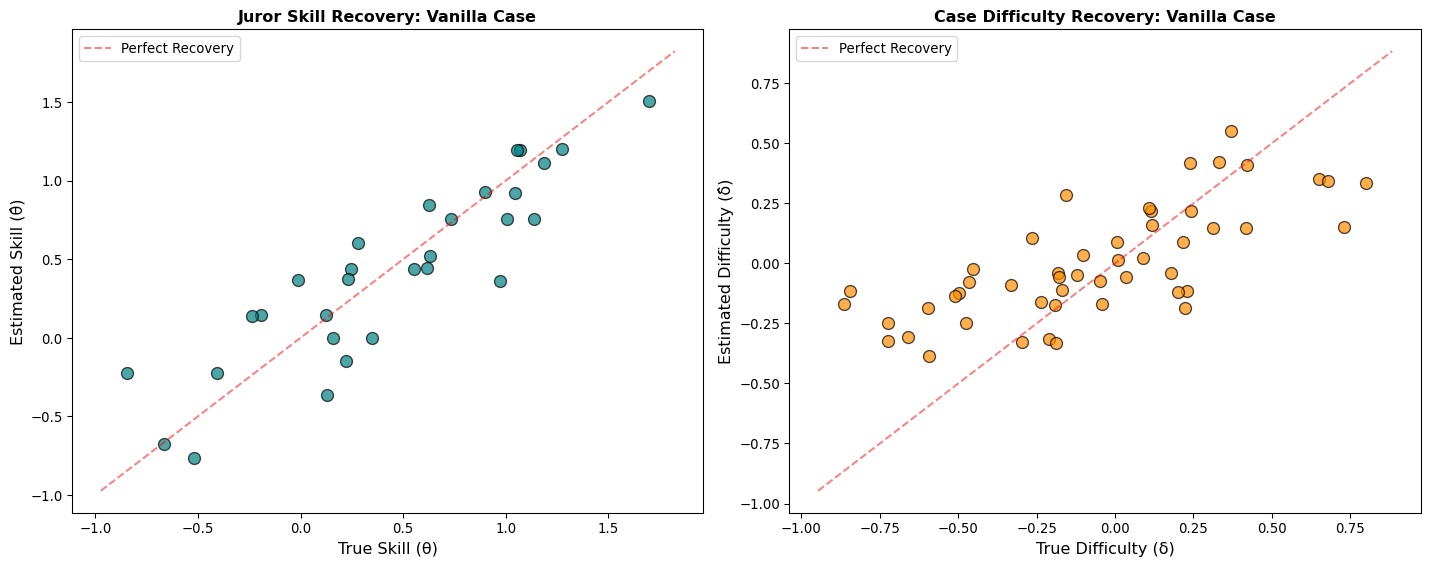

In [8]:
print(f"\nEstimated parameters:")
print(f"  σ_θ: {idata_vanilla.posterior['sigma_theta'].mean():.3f}")
print(f"  σ_δ: {idata_vanilla.posterior['sigma_delta'].mean():.3f}")
plot_parameter_recovery(idata_vanilla, t_theta, t_delta, "Vanilla Case");

Here we check the model's vision. The recovery plots compare the model’s estimated values for juror skill and case difficulty against the actual "ground truth" we programmed into the simulation. The recovery looks good. Next we want to ensure errors are independent.


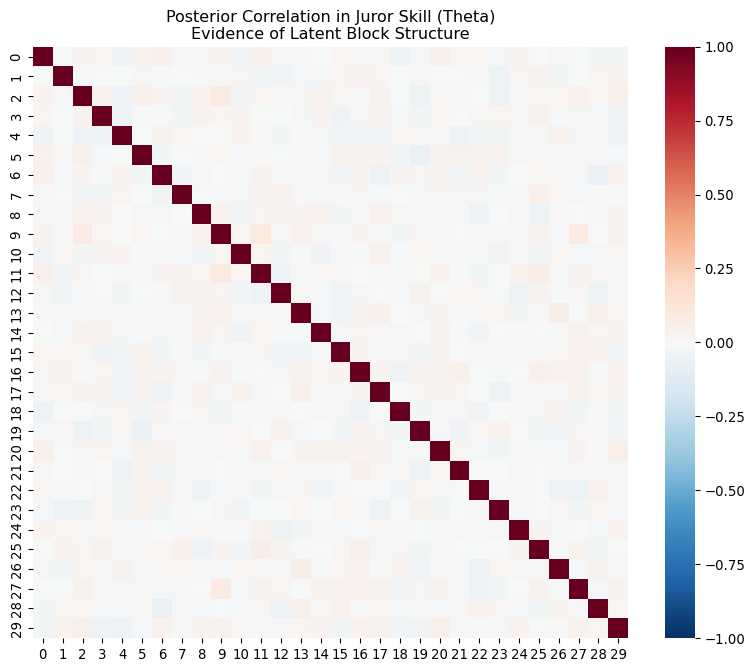

In [9]:
results_vanilla = compute_majority_accuracy_simple(
    idata_vanilla, truth_vanilla, JURY_SIZES, BLOCK_ID, n_samples=500
)

plot_skill_corr(idata_vanilla);

The heatmap for the Vanilla model is a field of blue-white "static." There are no dark clusters. In this environment, every person added to the room is a "Whole Person." Because their errors are uncorrelated, their individual perspectives provide additive value. If you have 30 people, you have the collective power of 30 people.


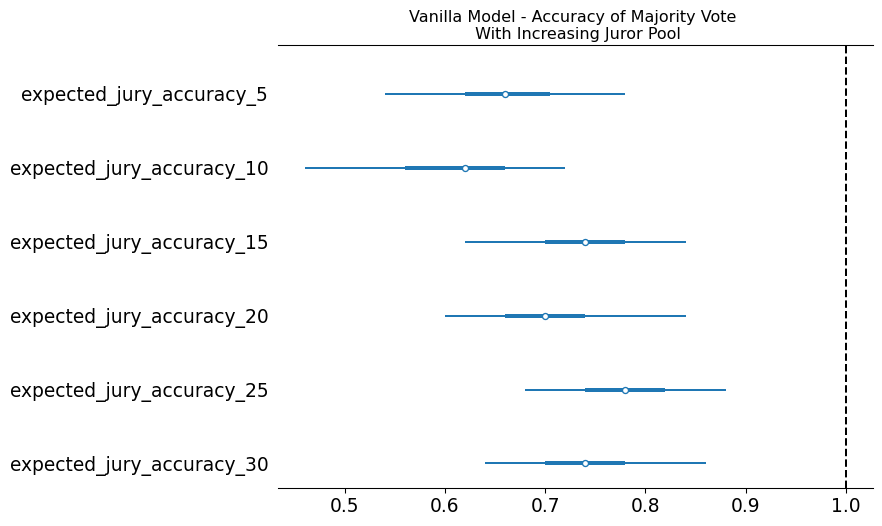

In [10]:
ax = az.plot_forest(idata_vanilla, var_names=['expected_jury_accuracy_5', 'expected_jury_accuracy_10', 'expected_jury_accuracy_15', 'expected_jury_accuracy_20', 'expected_jury_accuracy_25' ,'expected_jury_accuracy_30'], combined=True, figsize=(8, 6));
ax[0].axvline(1, linestyle='--', color='k')
ax[0].set_title("Vanilla Model - Accuracy of Majority Vote \n With Increasing Juror Pool");


Finally, we look at accuracy. As we scale the jury size from 5 to 30, we see the classic Condorcet upward sweep. We're still only using 30 jurors but the conditions are such that if we scale the jurors further we would expect increased accuracy.


### The Block IRT model: Skill Difference, Difficulty and Block effects

Now we introduce Blocks. We’ve simulated an organization where individuals have been "aligned" into three distinct factions. This might represent departments (Engineering vs. Sales), regional offices, or simply different "schools of thought" within the C-suite.

The management team loves this predictable, legible structure. You can manage three block leaders much more easily than 30 independent jurors. But as we’re about to see, this management convenience comes with a steep epistemic tax.



Estimated parameters:
  σ_θ: 1.876
  σ_δ: 2.149
  σ_block: 1.363


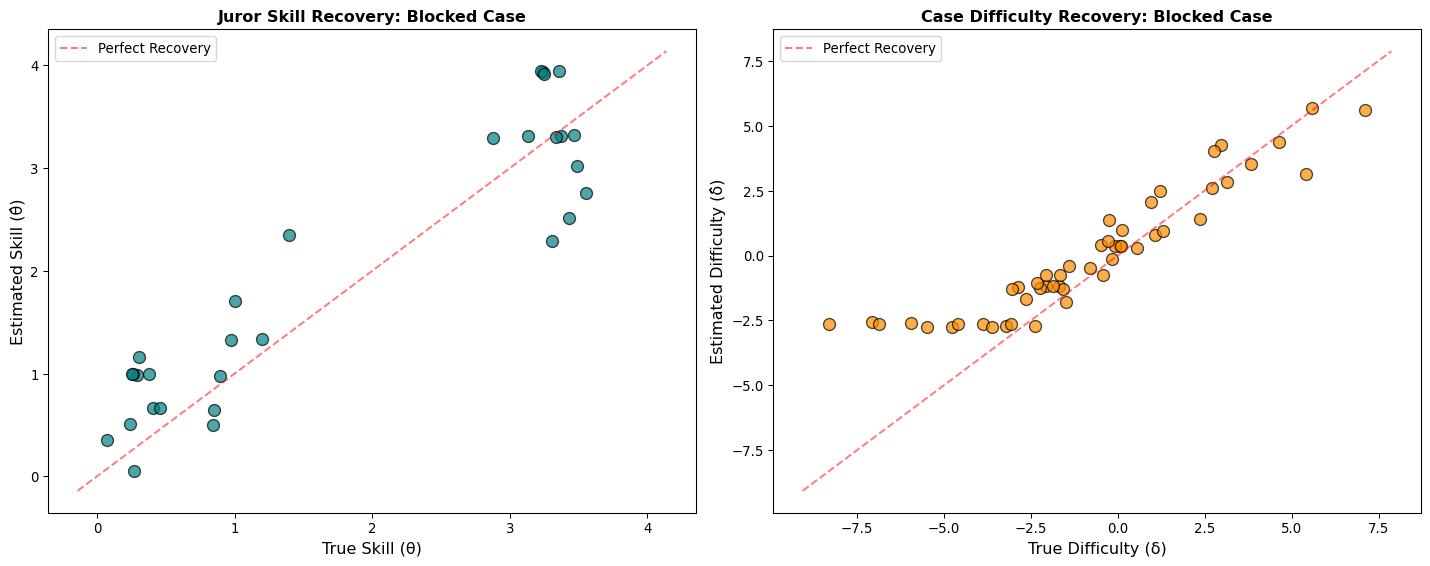

In [11]:
print(f"\nEstimated parameters:")
print(f"  σ_θ: {idata_blocked.posterior['sigma_theta'].mean():.3f}")
print(f"  σ_δ: {idata_blocked.posterior['sigma_delta'].mean():.3f}")
print(f"  σ_block: {idata_blocked.posterior['sigma_block'].mean():.3f}")

plot_parameter_recovery(idata_blocked, t_theta_blocked, t_delta_blocked, "Blocked Case");


The parameter Recovery shows the erosion of the individual. In the Blocked Case, the recovery plot for Juror Skill ($\theta$) pulls all individual towards block competence. Because $\sigma_{block}$ is so high, the individual’s own talent is being physically "drowned out" by the group identity. In a high-alignment culture, it becomes nearly impossible to tell who is actually talented and who is just a "culture fit." The "Block Gravity" pull is so strong that individual brilliance is indistinguishable from group adherence.



Computing accuracy by jury size...


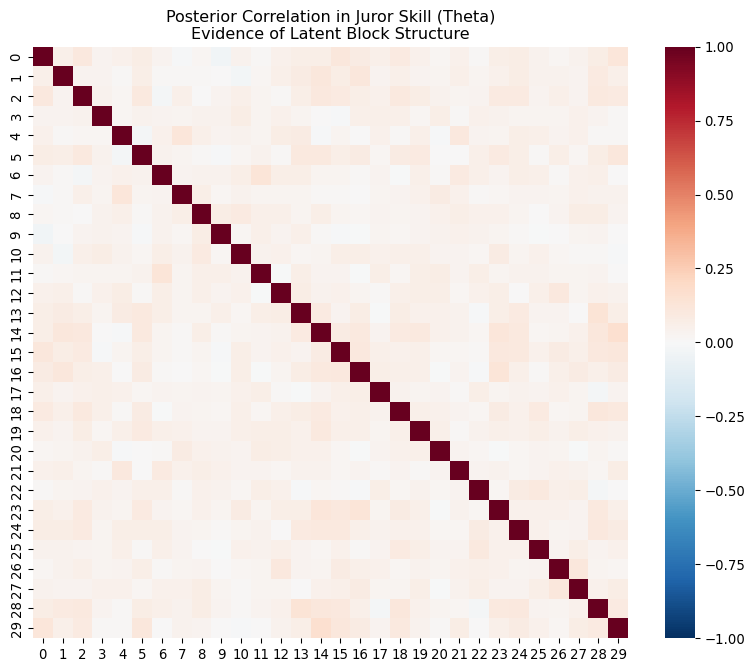

In [12]:
print("\nComputing accuracy by jury size...")
results_blocked = compute_majority_accuracy_simple(
    idata_blocked, truth_blocked, JURY_SIZES, BLOCK_ID, n_samples=500
)
plot_skill_corr(idata_blocked);

Unlike the white noise of the Vanilla model, we now see dark red squares along the diagonal. Statistically, this organization doesn't have 30 employees, the signal is diminished through swamping effects of the block.


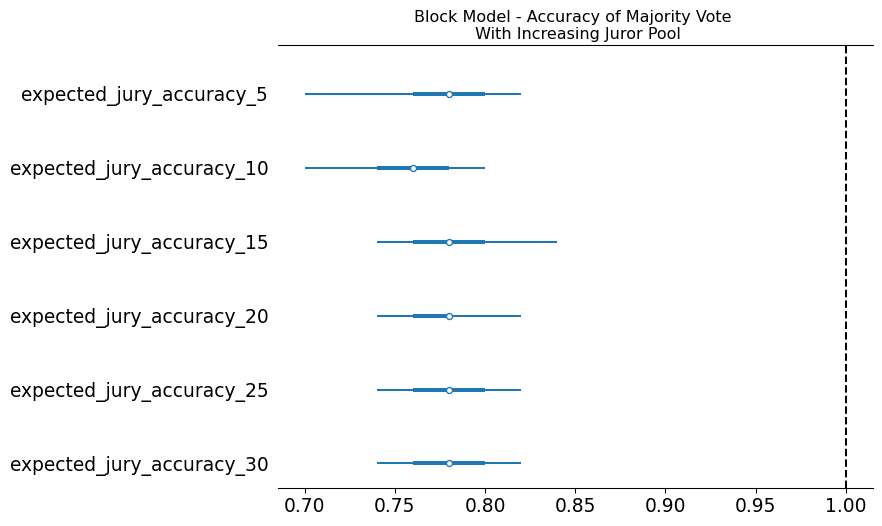

In [13]:
ax = az.plot_forest(idata_blocked, var_names=['expected_jury_accuracy_5', 'expected_jury_accuracy_10', 'expected_jury_accuracy_15', 'expected_jury_accuracy_20', 'expected_jury_accuracy_25' ,'expected_jury_accuracy_30'], combined=True, figsize=(8, 6));
ax[0].axvline(1, linestyle='--', color='k')
ax[0].set_title("Block Model - Accuracy of Majority Vote \n With Increasing Juror Pool");

Even as we add 10, 20, or 30 jurors, the accuracy doesn't improve significantly. Why? Because if the "Block" is wrong about a specific hard case, adding more members of that block just increases the confidence in the error, not the chance of finding the truth. 

### The Full IRT model: Difference, Difficulty, Blocks and Hetereogenous Noise

In the Full Model, we see a more subtle flavour of the Legibility Trap. Here, the blocks aren't "Groupthink" (negative/error-prone); they are "Expertise" (positive/competent). But despite the block effects we see a range of juror skills unlike in the previous model.



Estimated parameters:
  σ_θ: 0.746
  σ_δ: 3.047
  σ_block: 0.882
  τ: 1.549


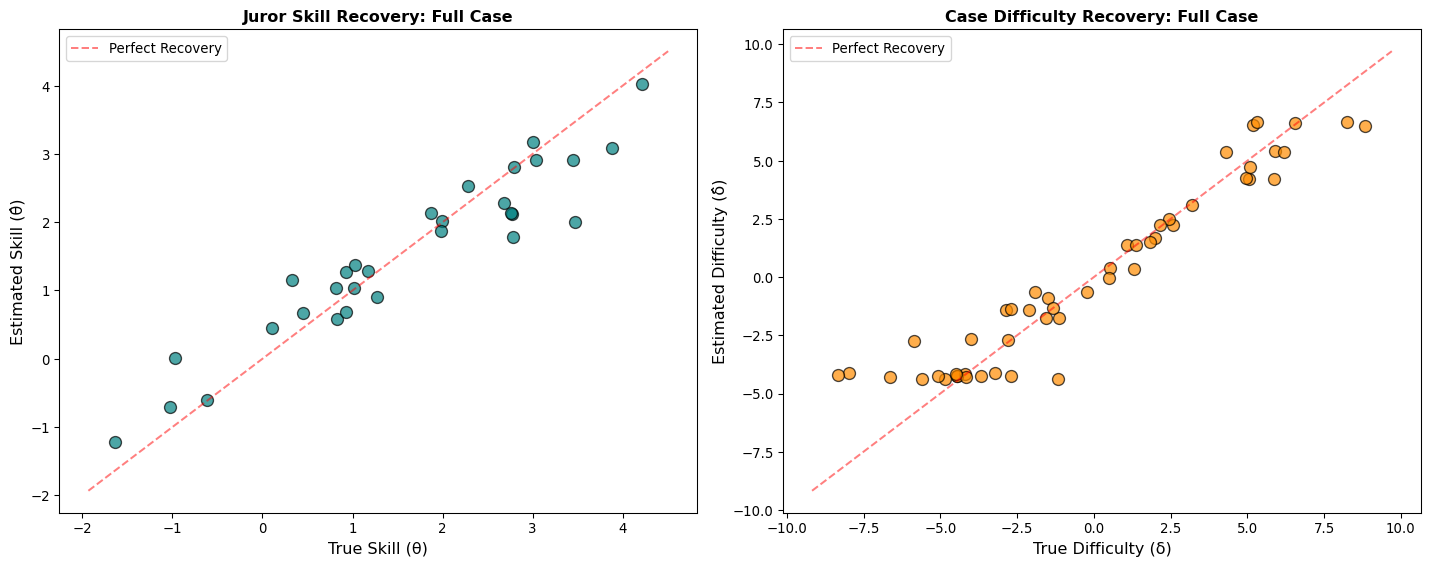

In [14]:
print(f"\nEstimated parameters:")
print(f"  σ_θ: {idata_full.posterior['sigma_theta'].mean():.3f}")
print(f"  σ_δ: {idata_full.posterior['sigma_delta'].mean():.3f}")
print(f"  σ_block: {idata_full.posterior['sigma_block'].mean():.3f}")
print(f"  τ: {idata_full.posterior['tau'].mean():.3f}")

plot_parameter_recovery(idata_full, t_theta_full, t_delta_full, "Full Case");

The parameter recovery shows reduced clustering on individual competence around the block effects. Where it seems that $\tau$ dominates $\sigma_{block}$ and represents the decoupling force i.e the specific organizational or individual intervention required to break the 'gravitational pull' of the block and restore independent signal. But we also see a straightline in the lower difficulty parameter plot. This is related to the high level of competence making easier cases almost certainly correctly identified. The organization becomes "stuck in its own success." Because it is so good at the (easy) cases, it stops valuing the "Independent Friction" ($\tau$) needed to solve the hard ones. The flat line represents a state of optimal sub-optimization: you are 100% accurate on the trivial, which masks the fact that you have lost the ability to scale your intelligence on the complex. We can see this further by looking at the correlations. 



Computing accuracy by jury size...


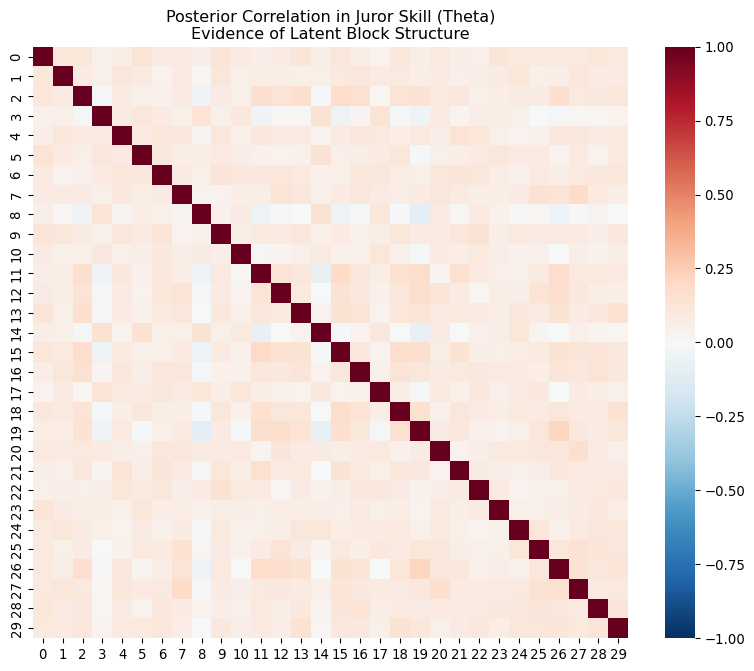

In [15]:
print("\nComputing accuracy by jury size...")
results_full = compute_majority_accuracy_simple(
    idata_full, truth_full, JURY_SIZES, BLOCK_ID, n_samples=500
)

plot_skill_corr(idata_full)


The treatment ($\tau$) successfully reduces structural correlation by inducing differential individual competence. We can imagine these treatments as training in radical candour, or similar inducements to challenge the status quo. But shared difficulty  of the problem space and common treatment still drives a consistent error rates which translates to a latent correlation. The heatmap should show that the dark squares of the Blocked Model have been "shattered" into a lighter, more fragmented pattern. But we retain a low-grade common correlation. It can be read as tragedy of good intentions. Management aims to decorrelate individual error through better training, but the training is a blunt instrument and just embeds shared methodological truisms and ways of working. Because of this combination of factors, the accuracy curve remains flat. 


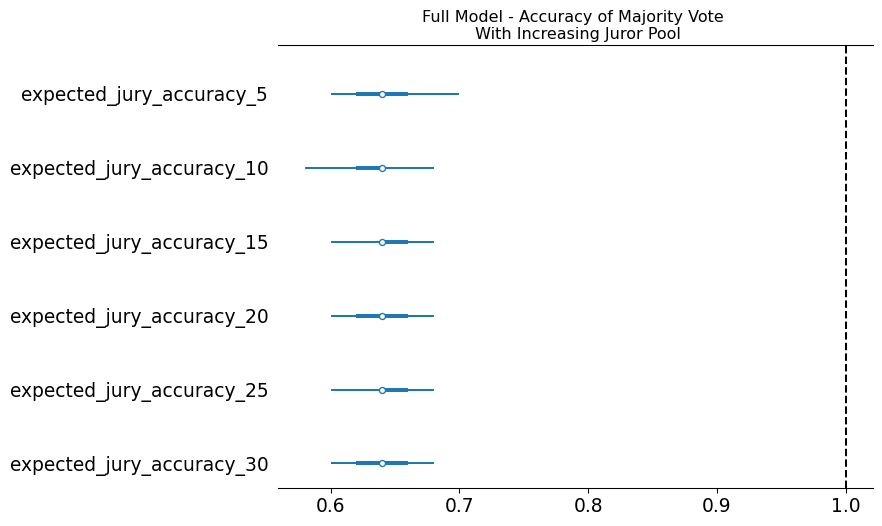

In [16]:
ax = az.plot_forest(idata_full, var_names=['expected_jury_accuracy_5', 'expected_jury_accuracy_10', 'expected_jury_accuracy_15', 'expected_jury_accuracy_20', 'expected_jury_accuracy_25' ,'expected_jury_accuracy_30'], combined=True, figsize=(8, 6));
ax[0].axvline(1, linestyle='--', color='k')
ax[0].set_title("Full Model - Accuracy of Majority Vote \n With Increasing Juror Pool");

Adding more "experts" from the same block doesn't help because they all fail on the same "Hard" cases ($\delta_i$). We have optimized for a specific type of excellence, and in doing so, you have sacrificed the diversity of error required to cross the final threshold to 100% accuracy. We can see how the accuracy doesn't move as we scale the $\tau$ parameter.


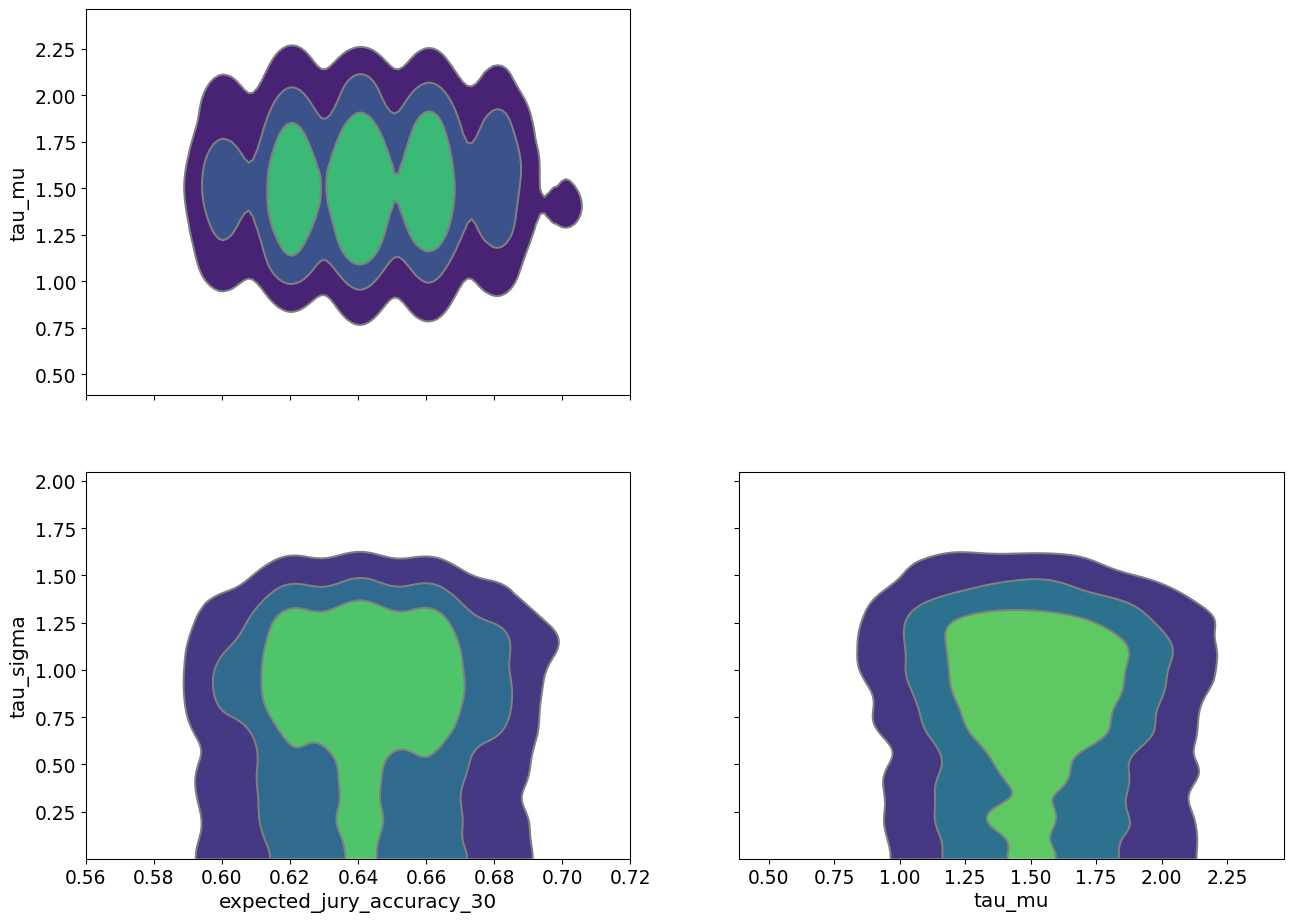

In [17]:
az.plot_pair(idata_full, var_names=['expected_jury_accuracy_30', 'tau_mu', 'tau_sigma'], kind='kde');

The pair plot reveals the "Exchange Rate" between independence and performance. If `tau_mu` is high but `expected_jury_accuracy` is flat, it tells us that the organization has hit diminishing returns on independence. The "Legibility" of the expertise-based block is so dominant that even significant individual effort ($\tau$) can't provide the missing signal. This is likely due to genuinely extreme difficulty of the cases. The lesson is that while diversity of opinion is necessary for majority accuracy to converge it is not sufficient. If the problem is beyond the competence of the jury pool, accuracy will plateau at their limit. Indepdence is a necessary but not sufficient condition to drive accuracy gains through aggregation. But here again, the solution is give up or hire more diverse competence.

### Comparing the IRT models: Rate of Learning

One species of fallacy assumes that if you hire A-Players (High $\theta$) and align them into blocks (High $\beta$), you get a perfect organization. Our models shows that to be quite a brittle operating model:

- The Vanilla Model shows that Independence is the actual engine of growth.

- The Blocked Model shows that Alignment can be an engine of stagnation.

- The Full Model shows that even Expert Alignment creates a "competence trap" where you are too fixated to be truly intelligent. Hard problems still fall beyond the scope of locally convergent competence.

As C. Thi Nguyen might put it: the organization has "captured" the value of expertise so effectively that it has lost the ability to see anything that falls outside of its chosen metrics. The organisation is often "right" in a very legible way, but you are permanently blind to the "illegible" truths that a messy, unorthodox organization might have caught.


In [18]:
results_dict = {
        'vanilla': results_vanilla,
        'blocked': results_blocked,
        'full': results_full
    }
    
print_accuracy_table(results_dict, JURY_SIZES)



DETAILED ACCURACY COMPARISON

VANILLA:
  Size  3: 0.640 [0.520, 0.760]
  Size  5: 0.660 [0.560, 0.760]
  Size  7: 0.680 [0.579, 0.800]
  Size 10: 0.700 [0.600, 0.800]
  Size 15: 0.740 [0.640, 0.840]
  Size 20: 0.760 [0.640, 0.860]
  Size 30: 0.800 [0.700, 0.880]

BLOCKED:
  Size  3: 0.760 [0.700, 0.820]
  Size  5: 0.780 [0.720, 0.820]
  Size  7: 0.780 [0.720, 0.820]
  Size 10: 0.780 [0.740, 0.820]
  Size 15: 0.780 [0.740, 0.820]
  Size 20: 0.780 [0.740, 0.820]
  Size 30: 0.780 [0.760, 0.820]

FULL:
  Size  3: 0.640 [0.600, 0.700]
  Size  5: 0.660 [0.600, 0.700]
  Size  7: 0.660 [0.619, 0.700]
  Size 10: 0.640 [0.600, 0.700]
  Size 15: 0.640 [0.600, 0.680]
  Size 20: 0.640 [0.620, 0.700]
  Size 30: 0.640 [0.620, 0.680]

IMPROVEMENT FROM SIZE 3 → 15
vanilla : 0.640 → 0.740 (Δ = +0.100, +15.6%)
blocked : 0.760 → 0.780 (Δ = +0.020, +2.6%)
full    : 0.640 → 0.640 (Δ = +0.000, +0.0%)


We can plot the achieved accuracy by jury size.


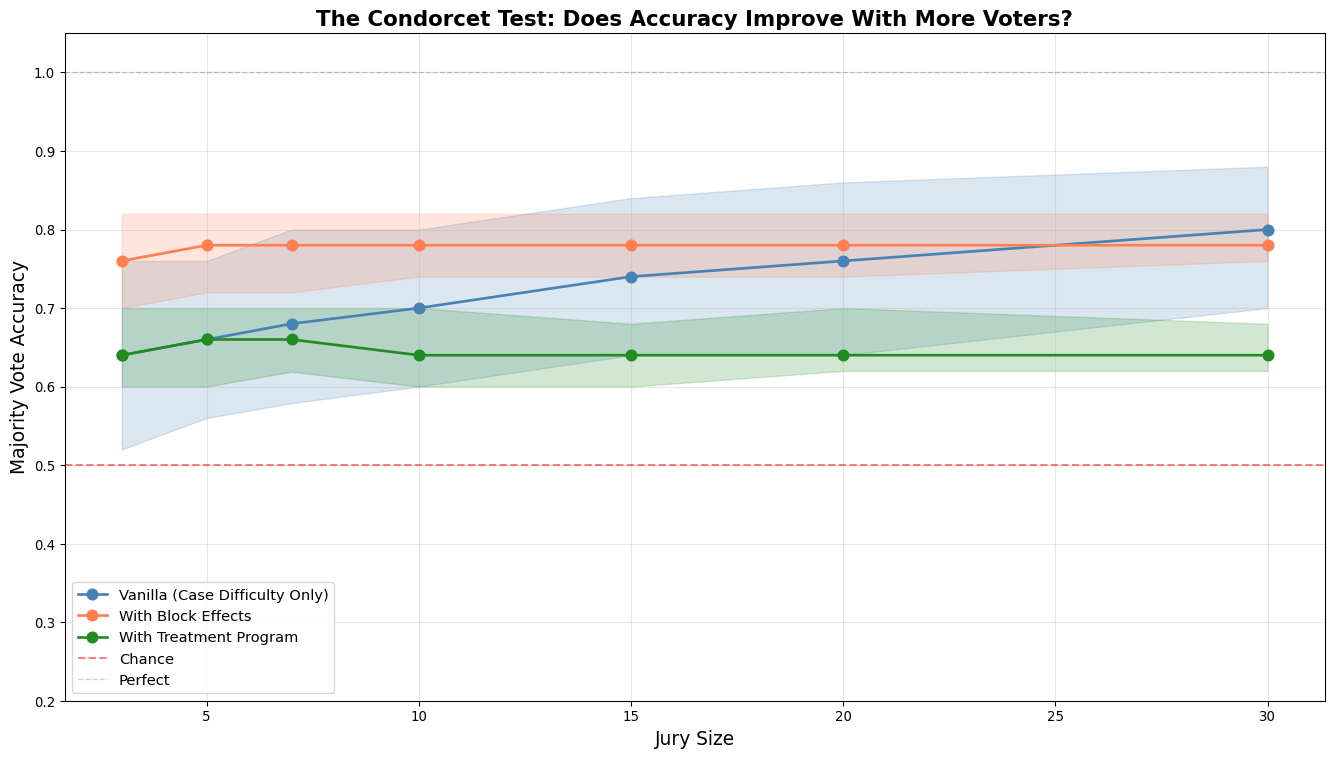

In [19]:
fig, ax = plot_accuracy_comparison(results_dict, JURY_SIZES)
plt.show()


However, looking at raw accuracy can be deceptive. A model with high baseline competence (like our Expert Block) might look successful simply because it starts from a higher point. To truly understand if an organization is learning—that is, if it is successfully aggregating independent signal—we must control for these different baselines.

By transforming our results into relative log-odds, we can isolate the Convergence Rate. This tells us how much "work" each additional employee is doing for the collective intelligence.


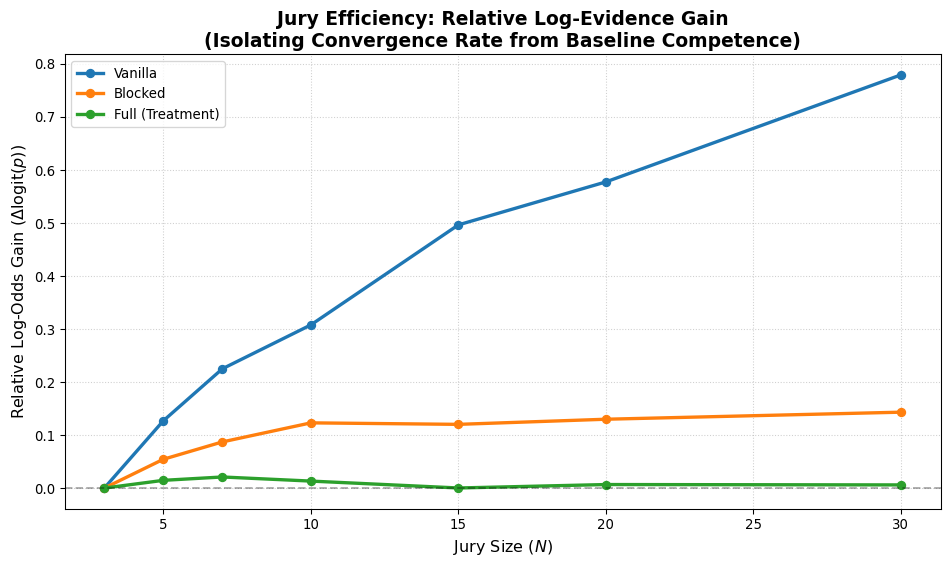

In [20]:
accuracy_dict = {
"Vanilla": [results_vanilla[size].mean() for size in JURY_SIZES],
"Blocked": [results_blocked[size].mean() for size in JURY_SIZES],
"Full (Treatment)": [results_full[size].mean() for size in JURY_SIZES]
}

# Now call the efficiency plotter
plot_condorcet_efficiency(JURY_SIZES, accuracy_dict);


The results reveal the high cost of incentivised legibility:

- The Vanilla Case: Exhibits the steady, logarithmic convergence expected of the Condorcet Jury Theorem. Every new voice adds new evidence.

- The Blocked Case: The slope is crushed. Groupthink doesn't just lower accuracy; it destroys the scaling of accuracy. Adding more voters provides diminishing returns because the errors are correlated.

- The Full Model (Expertise Trap): Here, we see a high baseline but a flat efficiency line. 

Because accuracy is strongly driven by the block effects (expertise), the expected accuracy is insensitive to any degree of treatment intervention.


#### The Role and Locus of Competence

The first line of defense for the "Legible" organization is hiring. The assumption is simple: if the system is failing, the "units" (employees) must be defective. This view assumes that if we just hire "A-Players" with high individual competence ($p > 0.5$), the organization will inevitably succeed. This is often a convenient fantasy. It's a fantasy compounded by annual performance assessment which grade on an artificial curve. It's easier to diagnose failure as limited competence when you regularly orchestrate a system to label a portion of the workforce as incompetent. It aligns with Nguyen's concept of metrics gaming — the belief that maximizing individual scores sums to a maximized collective outcome. It's a failure mode that ignores strucutural aspects of the organisation's problems in lieu of easier proxies. 

This is not to say that incompetence doesn't exist in a business or political organisation, but variations in competence are less of a threat to organisational competence and execution than the latent determinants of decision accuracy in the business. These determinants are generally structural or institutional; the problems we pick and the structure of decision mechanisms. The process of hiring and firing certainly changes the distribution of competence, it does not, as we've seen, ensure the onset of collective wisdom. 

This pulls us in two ways: (1) management panic over hiring standards and (2) and mission driven culture fit. On the one hand increased competence in the worker base is an objective good, but the drive for alignment reduces the set of competent actors that matter for decision making.  When workers are expected to "fall in line," responsibility and accountability should correspondingly concentrate within the executive class. It rarely does.

## Conclusion: The High Cost of Harmony

The statistical breakdown of the Condorcet Jury Theorem is not a bug in corporate planning; it is a feature of the fundamental tension in cooperative work. Our models have mapped a persistent tug-of-war between two opposing gravitational forces:

- **The Pull for Legibility (Scott):** This is the drive to make a complex organization understandable to investors and leaders. It builds the "blocks," the standardized workflows, and the shared cultures that allow thousands of people to move in the same direction. Without it, there is only chaos.

- **The Push for Autonomy (Nguyen):** This is the individual’s resistance to **Value Capture**. It is the drive to maintain a high-fidelity perspective on reality that hasn't been flattened by a KPI. Without it, there is only lockstep failure.

#### The Fragility of Alignment

We often treat "Alignment" as an unalloyed good. But our simulation of the **Expertise Trap** reveals that when we let the pull for Legibility dominate, we create an **accuracy ceiling**. 

In the pursuit of a "bankable" process, we inadvertently destroy the very thing that makes a group smarter than an individual: the friction of uncorrelated perspectives. When everyone is trained to see the world through the same lens, they share the same blind spots. The organization becomes perfectly legible—it is easy to manage on a spreadsheet—but it becomes epistemically compromised. 

#### The Value of Productive Discomfort
The point is that collective Wisdom is expensive. Its price is the discomfort of discordance. The "Legibility Trap" is seductive because it offers the illusion of control. It is much easier to manage three predictable blocks than thirty "unaligned" individuals. However, as the **Effective Jury Size ($N_{eff}$)** collapses, so does the organization’s ability to solve hard problems.

Solving "Hard" problems (the ones on the steep, unforgiving part of our difficulty curve) requires us to intentionally preserve independence To build a truly intelligent organization, leadership must move beyond the Technocratic Fantasy. It requires a deliberate tolerance for the "messy" and the "unaligned." True collective intelligence depends on **Autonomy**—the courage to let individuals maintain their own maps of the world, even when those maps make the organization harder to read. 

In the end, we must choose: do we want an organization that is easy to see, or one that is actually capable of seeing?

## Coda: Shared Priors and Foundation Models
We've suggested throughout that "block" effects can warp outcomes in undesirable ways. There are endless drives to grouping behavior, but here we'll take a moment to focus on the effects of algorithmic scaffolding shapes information consumption and action. 

In 2003, Edward Tufte published a quietly cutting critique of PowerPoint titled *The Cognitive Style of PowerPoint*. He argued that software didn't just present information, but that it *structured how people thought*. The hierarchical bullet point list, the pressure to fit complex arguments on a single slide, the aesthetic of "professionalism" over precision. All of it conspired to flatten nuance and discourage rigorous analysis. It killed people. 

In particular, he argued that the loss of information due to pre-mature simplification, and the coddling of the executive class was responsible for the Columbia space shuttle disaster. Seven astronauts died for the sake of an audience imagined as busy.   

#### Powerpoint for Prose

I did use a large language model to critique and help refine the argument here. The need to be legible, the drive to be understood is powerful. Generative AI is a tool that pushes us towards a common diction, and a shared global prior. It is a remarkable technology with innumerable applications that I can't even begin to predict how it will shape our dispositions.

I did not use a large language model to think my thoughts for me. Like other technologies pushing for standardisation and external legibility, LLMs are useful, limiting and horrifying at the same time. Useful, because they encode a library of babel open to the curious. Limiting because consolidation of information drives conformity and diminishes independence of thought within you. Horrifying, because you want the free roaming ideas, speculative whims and jagged singularity of actual thought, not the funneled folly of algorithmic hallucinations. When even your errors aren't your own, you can't learn and you can barely contribute to the real diversity of opinion that solves actual problems.  

#### Tools for Thinking

Within any work you are pulled between the incentive of external legibility and seeking the satisfaction of a job well done. Different writers are pulled differently towards each of these poles. Some write primarily for the pleasure of self-illumination, others for the acclaim of recognition, or even just a moment of fleeting understanding. Ultimately for your work to be useful, for it to be informative it must resist the pull towards excessive standardisation. Crass regurgitation of poorly digested wisdom is useless when we now have it on tap. But you can search the library of babel to pull out hidden gems, and scaffold your thoughts to ascend to new ideas. In this latter respect, LLMs are a tool like any other. The risk is when tools replace thought. With AI fact-checkers, or automated performance reviews the push for legibility goes too far. Scott argues that society functions only when low-grade civil disobedience circumvents the foolishness of the law misapplied. A society that builds tools to think at scale must also cultivate the courage to think apart. Without that friction, we do not get collective wisdom or dynamic learning. We get stasis — efficient, legible, and catastrophically brittle. In such a society it's a moral obligation to think for yourself. It is part of the Bayesian workflow to test and re-test our models for sensitivity to our priors. This process of iterative refinement is the learning, and learning requires the feedback of stress testing.


#### False Binaries and Stylised Facts

The Condorcet Jury theorem relies on the Stylised fact that the world presents us an array of 0/1 choices. The tension we've been discussing suggests the world pulls us between incentivised legibility and genuine autonomy. While the tension is real, it's a little too crude to pretend this is a binary decision. So while the advent of Generative AI and the proliferation of foundation models weights the scale toward incentivised legibility and starkly standardised process, the world does not exist in the training data. There is a real opportunity to use this technology to scaffold your thoughts, and climb to levels unimagined even six months ago, but there is also a real risk. The frictionless epistemology of LLM aided discovery is the real toy-model. It's a massively scaled and impressively competent toy model, but it still smoothes over the fruitful friction of testing our ideas against the world. The drive for homogeneity, like the push to find answers in the training data represents a retreat from the world and divestment of responsibility when we can least afford it. 

The current ownership of foundation models concentrates a lot of power in the hands of the few. This is not benign. We're already seeing weaponised usage of AI to funnel information, and foment dissent. This is a malicious optimisation of block-effects used to compound division and cloud real signal. Using these tools to "pump out" racist or political content effectively launders past biases into future "facts," creating a feedback loop that drags down voter competence.

Collective wisdom is not a gift of technology; it is the hard-won dividend of our refusal to think in lockstep. Your most vital role, when the choir is auto-tuned, is to cultivate your own discordant song. 